## Load libraries

In [73]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import random

import matplotlib.pyplot as plt

%matplotlib inline

try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

## Load data

In [222]:
max_n_past_timestamps = 64

In [277]:
fields = ['f', 'i0'] + [f'd{i}' for i in range(1, max_n_past_timestamps)]
x_fields = ['i0'] + [f'd{i}' for i in range(1, max_n_past_timestamps)]
y_field = ['f']

In [356]:
df = pd.read_csv('/data/zhenyus/webcachesim/snapshot_1.log', delimiter=',', names=fields)
# df = pd.read_csv('/data/zhenyus/webcachesim/snapshot_0.log', delimiter=',', names=fields)

In [357]:
df.head()

,f,i0,d1,d2,d3,d4,d5,d6,d7,d8,...,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63
0,63.0,1642,391.0,80.0,177.0,477.0,952.0,46.0,918.0,342.0,...,46.0,8.0,157.0,73.0,32.0,59.0,205.0,30.0,12.0,57.0
1,127.0,12,73.0,488.0,30.0,277.0,284.0,129.0,2.0,31.0,...,29.0,32.0,26.0,78.0,24.0,32.0,65.0,73.0,39.0,9.0
2,230285.0,226052,3125643.0,302490.0,99125.0,1803092.0,434359.0,27183.0,3421939.0,560114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,463297.0,2518097,207307.0,3180402.0,1716617.0,704867.0,349071.0,1171630.0,152005.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5666753.0,6059571,3940424.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [358]:
df = df[~pd.isna(df.d2)].reset_index()
df.head()

,index,f,i0,d1,d2,d3,d4,d5,d6,d7,...,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63
0,0,63.0,1642,391.0,80.0,177.0,477.0,952.0,46.0,918.0,...,46.0,8.0,157.0,73.0,32.0,59.0,205.0,30.0,12.0,57.0
1,1,127.0,12,73.0,488.0,30.0,277.0,284.0,129.0,2.0,...,29.0,32.0,26.0,78.0,24.0,32.0,65.0,73.0,39.0,9.0
2,2,230285.0,226052,3125643.0,302490.0,99125.0,1803092.0,434359.0,27183.0,3421939.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,463297.0,2518097,207307.0,3180402.0,1716617.0,704867.0,349071.0,1171630.0,152005.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1562424.0,5863744,2876270.0,1259980.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [360]:
threshold = int(1e7)

In [361]:
df.loc[pd.isna(df['f']), 'f'] = threshold
df = np.log1p(df)

In [364]:
df.head()

,index,f,i0,d1,d2,d3,d4,d5,d6,d7,...,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63
0,0.000000,4.158883,7.404279,5.971262,4.394449,5.181784,6.169611,6.859615,3.850148,6.823286,...,3.850148,2.197225,5.062595,4.304065,3.496508,4.094345,5.327876,3.433987,2.564949,4.060443
1,0.693147,4.852030,2.564949,4.304065,6.192362,3.433987,5.627621,5.652489,4.867534,1.098612,...,3.401197,3.496508,3.295837,4.369448,3.218876,3.496508,4.189655,4.304065,3.688879,2.302585
2,1.098612,12.347077,12.328525,14.955151,12.619807,11.504147,14.405014,12.981629,10.210384,15.045718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.386294,13.046126,14.739014,12.241961,14.972518,14.355867,13.465766,12.763033,13.973907,11.931675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.791759,14.261750,15.584299,14.872005,14.046607,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [365]:
permutation_idx = np.random.RandomState(seed=42).permutation(len(df))

In [366]:
pivot = int(len(permutation_idx)*0.7)
train_idx = permutation_idx[:pivot]
test_idx = permutation_idx[pivot:]

In [367]:
X_train = df[x_fields].loc[train_idx]
y_train = df[y_field].loc[train_idx]

X_test = df[x_fields].loc[test_idx]
y_test = df[y_field].loc[test_idx]

## Create Dataset object for LightGBM

In [368]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

## Configuration dictionary

In [369]:
params = {
    'metric': ['l1', 'l2'],
    'verbose': -1,
    'objective': 'regression',
}

## Training

In [370]:
evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                feature_name=x_fields,
                evals_result=evals_result,
                verbose_eval=10)

[10]	training's l2: 1.79769	training's l1: 1.04088	valid_1's l2: 1.81614	valid_1's l1: 1.0459
[20]	training's l2: 1.69134	training's l1: 1.0042	valid_1's l2: 1.70888	valid_1's l1: 1.0092
[30]	training's l2: 1.67224	training's l1: 0.996894	valid_1's l2: 1.69107	valid_1's l1: 1.00206
[40]	training's l2: 1.66567	training's l1: 0.994452	valid_1's l2: 1.68709	valid_1's l1: 1.00024
[50]	training's l2: 1.66186	training's l1: 0.993132	valid_1's l2: 1.68623	valid_1's l1: 0.999741
[60]	training's l2: 1.65883	training's l1: 0.99213	valid_1's l2: 1.68623	valid_1's l1: 0.999662
[70]	training's l2: 1.65639	training's l1: 0.991313	valid_1's l2: 1.68618	valid_1's l1: 0.999619
[80]	training's l2: 1.65407	training's l1: 0.990567	valid_1's l2: 1.68633	valid_1's l1: 0.999655
[90]	training's l2: 1.65173	training's l1: 0.989824	valid_1's l2: 1.68645	valid_1's l1: 0.999687
[100]	training's l2: 1.64949	training's l1: 0.989121	valid_1's l2: 1.68662	valid_1's l1: 0.999729


## Plot metrics recorded during training

In [340]:
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()

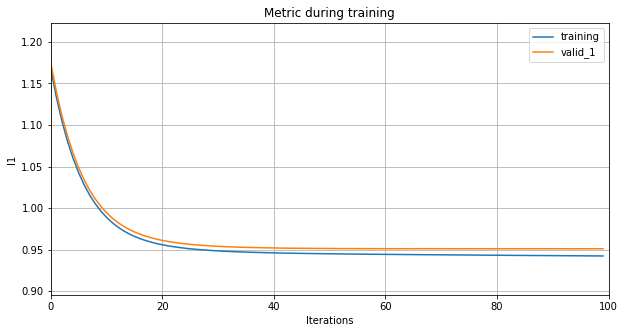

In [341]:
render_metric(params['metric'][0])

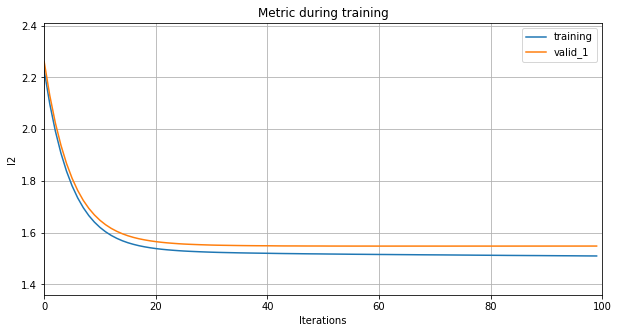

In [342]:
render_metric(params['metric'][1])

## Plot feature importances

In [343]:
def render_plot_importance(importance_type, max_features=10,
                           ignore_zero=True, precision=4):
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    plt.show()

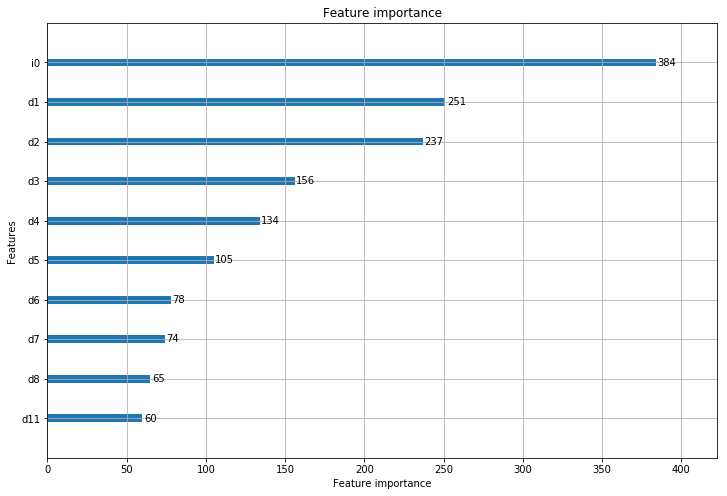

In [344]:
if INTERACTIVE:
    # create widget for interactive feature importance plot
    interact(render_plot_importance,
             importance_type=['split', 'gain'],
             max_features=(1, X_train.shape[-1]),
             precision=(0, 10))
else:
    render_plot_importance(importance_type='split')

## Plot trees

In [345]:
def render_tree(tree_index, show_info, precision=4):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(gbm, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

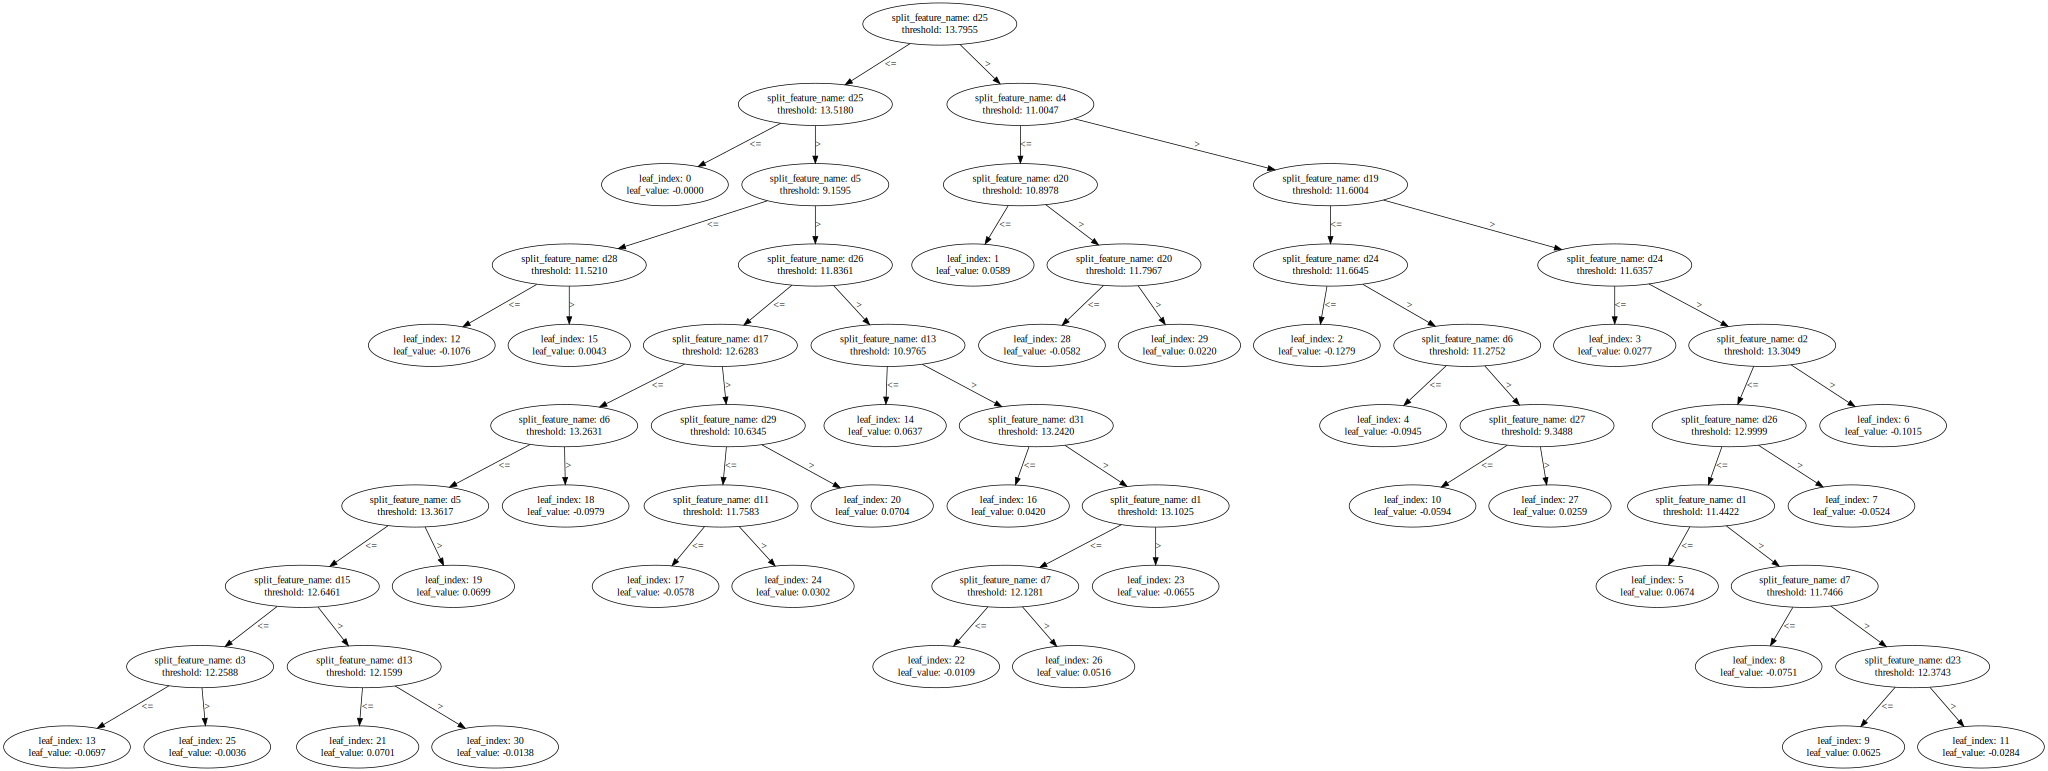

In [346]:
tree = render_tree(84, ['None'])
tree

In [347]:
gbm.predict(X_test).min()

6.285642722322524

In [348]:
gbm.predict(X_test).max()

15.349999162338666

In [349]:
y = gbm.predict(X_test)

(array([3.0000e+00, 1.0000e+00, 4.0000e+00, 5.0000e+00, 6.0000e+00,
        1.3000e+01, 4.0000e+00, 8.0000e+00, 1.5000e+01, 1.2000e+01,
        1.8000e+01, 1.5000e+01, 9.0000e+00, 1.8000e+01, 2.1000e+01,
        2.7000e+01, 3.6000e+01, 2.4000e+01, 4.8000e+01, 2.9000e+01,
        3.7000e+01, 3.7000e+01, 5.9000e+01, 6.4000e+01, 6.8000e+01,
        6.1000e+01, 6.8000e+01, 6.5000e+01, 7.5000e+01, 7.2000e+01,
        8.3000e+01, 1.2300e+02, 1.1600e+02, 1.5300e+02, 1.5800e+02,
        1.6900e+02, 2.2800e+02, 2.5700e+02, 2.7700e+02, 3.6000e+02,
        3.8300e+02, 4.7600e+02, 5.3000e+02, 6.6500e+02, 7.6700e+02,
        7.9500e+02, 1.0610e+03, 1.2290e+03, 1.3660e+03, 1.5980e+03,
        1.7670e+03, 2.0930e+03, 2.4630e+03, 2.8620e+03, 3.4110e+03,
        3.9960e+03, 4.7290e+03, 4.5580e+03, 5.3640e+03, 8.4860e+03,
        6.0940e+03, 1.0116e+04, 2.9550e+03, 1.4483e+04, 1.5746e+04,
        9.5130e+03, 2.9282e+04, 3.6810e+03, 1.5568e+04, 7.3943e+04]),
 array([ 6.28564272,  6.41513353,  6.54462433,

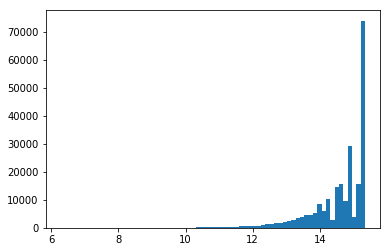

In [350]:
plt.hist(y, bins=70)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00, 2.0000e+00,
        3.0000e+00, 8.0000e+00, 1.2000e+01, 1.4000e+01, 1.7000e+01,
        1.0000e+01, 2.0000e+01, 1.5000e+01, 3.0000e+01, 2.5000e+01,
        2.8000e+01, 4.8000e+01, 6.7000e+01, 5.8000e+01, 6.9000e+01,
        8.6000e+01, 1.1800e+02, 1.3300e+02, 1.3900e+02, 1.7000e+02,
        2.0000e+02, 2.3600e+02, 2.8300e+02, 3.6800e+02, 4.1300e+02,
        4.7600e+02, 6.0800e+02, 6.9300e+02, 9.7200e+02, 1.2210e+03,
        1.3970e+03, 1.5860e+03, 1.6680e+03, 1.9520e+03, 2.5550e+03,
        2.7560e+03, 3.1420e+03, 3.6670e+03, 4.2640e+03, 4.7250e+03,
        5.4910e+03, 6.2340e+03, 6.7400e+03, 7.3840e+03, 8.0890e+03,
        9.1870e+03, 1.1832e+04, 1.2908e+04, 1.2629e+04, 1.1323e+04,
        1.1644e+04, 1.1356e+04, 1.2722e+04, 9.8740e+03, 6.1141e+04]),
 array([ 1.38629436,  1.59674867,  1.80720297,

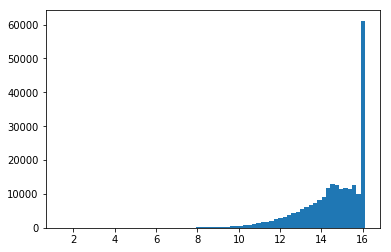

In [351]:
plt.hist(y_test.values, bins=70)

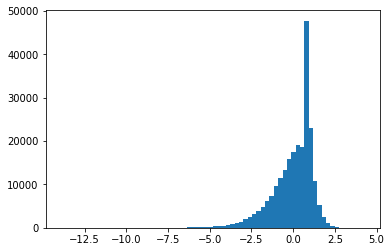

In [352]:
plt.hist(y_test.values[:, 0] - y, bins=70)
plt.show()

In [353]:
gbm.dump_model()

{'name': 'tree',
 'version': 'v2',
 'num_class': 1,
 'num_tree_per_iteration': 1,
 'label_index': 0,
 'max_feature_idx': 63,
 'feature_names': ['i0',
  'd1',
  'd2',
  'd3',
  'd4',
  'd5',
  'd6',
  'd7',
  'd8',
  'd9',
  'd10',
  'd11',
  'd12',
  'd13',
  'd14',
  'd15',
  'd16',
  'd17',
  'd18',
  'd19',
  'd20',
  'd21',
  'd22',
  'd23',
  'd24',
  'd25',
  'd26',
  'd27',
  'd28',
  'd29',
  'd30',
  'd31',
  'd32',
  'd33',
  'd34',
  'd35',
  'd36',
  'd37',
  'd38',
  'd39',
  'd40',
  'd41',
  'd42',
  'd43',
  'd44',
  'd45',
  'd46',
  'd47',
  'd48',
  'd49',
  'd50',
  'd51',
  'd52',
  'd53',
  'd54',
  'd55',
  'd56',
  'd57',
  'd58',
  'd59',
  'd60',
  'd61',
  'd62',
  'd63'],
 'tree_info': [{'tree_index': 0,
   'num_leaves': 31,
   'num_cat': 0,
   'shrinkage': 1,
   'tree_structure': {'split_index': 0,
    'split_feature': 6,
    'split_gain': 290600,
    'threshold': 1e+300,
    'decision_type': '<=',
    'default_left': False,
    'missing_type': 'NaN',
    '